<a href="https://colab.research.google.com/github/godot107/Colaboratory/blob/main/LSTM_Time_Series_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Global Data Science Project incorporates a challenge/problem to predict anomlies using time series data using LTSM

Goals:


Concepts:
1.

Research/Resources:
1.   https://github.com/srivatsan88/End-to-End-Time-Series/blob/master/Multivariate_Time_Series_Modeling_using_LSTM.ipynb

Future Endeavors:



General Notes:






In [ ]:
# Run at start of kernel

!pip install statsmodels
!pip install keras

In [ ]:
# Import Libraries

from google.colab import drive
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

import statsmodels.api as sm
import scipy.stats as stats

from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed




In [ ]:
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/GDSC4/Workbench/data/point_sensors/tabular


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/GDSC4/Workbench/data/point_sensors/tabular


In [ ]:
# Import data:
point_sensors_data = pd.read_csv("2013-10-03.csv") # noticed the raw data isn't ordered. but it is done for us via pandas.



In [ ]:
point_sensors_data.info()

point_sensors_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   datetime_index     1440 non-null   object 
 1   depth_m            1440 non-null   float64
 2   temp_c_at_depth    1440 non-null   float64
 3   chlorophyll_ugl    1440 non-null   float64
 4   conductivity_mscm  1440 non-null   float64
 5   temp_c             1440 non-null   float64
 6   turbidity_ftu      0 non-null      float64
 7   salinity_psu       1440 non-null   float64
dtypes: float64(7), object(1)
memory usage: 90.1+ KB


,depth_m,temp_c_at_depth,chlorophyll_ugl,conductivity_mscm,temp_c,turbidity_ftu,salinity_psu
count,1440.000000,1440.000000,1440.0,1440.000000,1440.000000,0.0,1440.000000
mean,255.328497,7.906080,0.0,36.212035,8.062132,NaN,34.806774
std,0.498634,0.061879,0.0,0.124169,0.070387,NaN,0.084843
min,254.630000,7.800000,0.0,36.040000,7.940000,NaN,34.580000
25%,254.830250,7.865000,0.0,36.130000,8.006917,NaN,34.746625
50%,255.315000,7.889333,0.0,36.169000,8.049583,NaN,34.788333
75%,255.815083,7.916333,0.0,36.236542,8.100000,NaN,34.856000
max,256.090000,8.030000,0.0,36.480000,8.200000,NaN,34.980000


**Pre-processing**

References: 





In [ ]:
# Pre-processing
# remove NAs
point_sensors_data['turbidity_ftu'] = 0
point_sensors_data = point_sensors_data.set_index('datetime_index')

#Filtering the data to a smaller window:



**EDA Visualizations**


Reference: 
*   https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
*   tilting axis: https://www.kite.com/python/answers/how-to-rotate-axis-labels-in-matplotlib-in-python
*   Fig size: https://stackoverflow.com/questions/14770735/how-do-i-change-the-figure-size-with-subplots
*   Working with legends: https://stackoverflow.com/questions/27016904/matplotlib-legends-in-subplot/27017307
*   Adding title: https://stackoverflow.com/questions/25239933/how-to-add-title-to-subplots-in-matplotlib



array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fdbc49c3510>,
      dtype=object)

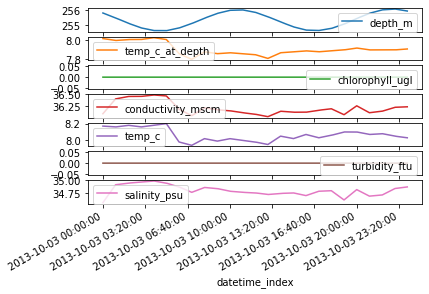

In [ ]:
point_sensors_data[['depth_m',	'temp_c_at_depth',	'chlorophyll_ugl',	'conductivity_mscm',	'temp_c',	'turbidity_ftu',	'salinity_psu']].plot(subplots=True)

**Building the LSTM Machine Learning Model**

Goals:

References:


1.   Tutorial: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
2.   Multi-variate: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
3.   Time Series Data Prepration Video Tutorial: https://www.youtube.com/watch?v=i4vGKgbtf1U
4.   AutoEncoders Video: https://www.youtube.com/watch?v=S31E-ftRfQI
5.   Article: https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf
6.   LTSM Theory: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
7.   Applying Multivariate Time Series Modeling using LSTM: https://www.youtube.com/watch?v=4FmVIpcwl4k
8.   Information on time series generator: https://machinelearningmastery.com/how-to-use-the-timeseriesgenerator-for-time-series-forecasting-in-keras/

Future Endeavor: 
1.   Add threshold line for anomalies to the last plot


In [ ]:
# Input Data:

df_input = point_sensors_data[['depth_m',	'temp_c_at_depth',	'chlorophyll_ugl',	'conductivity_mscm',	'temp_c',	'turbidity_ftu',	'salinity_psu']]

In [ ]:
# Scaling the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)
features = data_scaled 
target = data_scaled[:,4] # targetting temp_c


In [ ]:
pd.DataFrame(data_scaled)

,0,1,2,3,4,5,6
0,0.815068,0.956522,0.0,0.136364,0.884615,0.0,0.00000
1,0.811301,0.955072,0.0,0.147727,0.883974,0.0,0.01375
2,0.807534,0.953623,0.0,0.159091,0.883333,0.0,0.02750
3,0.803767,0.952174,0.0,0.170455,0.882692,0.0,0.04125
4,0.800000,0.950725,0.0,0.181818,0.882051,0.0,0.05500
...,...,...,...,...,...,...,...
1435,0.912100,0.474638,0.0,0.452652,0.352564,0.0,0.71875
1436,0.910502,0.475362,0.0,0.453030,0.351282,0.0,0.72000
1437,0.908904,0.476087,0.0,0.453409,0.350000,0.0,0.72125
1438,0.907306,0.476812,0.0,0.453788,0.348718,0.0,0.72250


In [ ]:
TimeseriesGenerator(features, target, length = 15, sampling_rate = 1, batch_size=1)[0] # length is the time window and in this case 60 minutes

(array([[[0.81506849, 0.95652174, 0.        , 0.13636364, 0.88461538,
          0.        , 0.        ],
         [0.81130137, 0.95507246, 0.        , 0.14772727, 0.88397436,
          0.        , 0.01375   ],
         [0.80753425, 0.95362319, 0.        , 0.15909091, 0.88333333,
          0.        , 0.0275    ],
         [0.80376712, 0.95217391, 0.        , 0.17045455, 0.88269231,
          0.        , 0.04125   ],
         [0.8       , 0.95072464, 0.        , 0.18181818, 0.88205128,
          0.        , 0.055     ],
         [0.79623288, 0.94927536, 0.        , 0.19318182, 0.88141026,
          0.        , 0.06875   ],
         [0.79246575, 0.94782609, 0.        , 0.20454545, 0.88076923,
          0.        , 0.0825    ],
         [0.78869863, 0.94637681, 0.        , 0.21590909, 0.88012821,
          0.        , 0.09625   ],
         [0.78493151, 0.94492754, 0.        , 0.22727273, 0.87948718,
          0.        , 0.11      ],
         [0.78116438, 0.94347826, 0.        , 0.2386363

In [ ]:
# Splitting the dataset:
x_train, x_test, Y_train, Y_test = train_test_split(features, target, test_size = .2, random_state = 1, shuffle = False) # shuffle = False because want to retain order of the time series. in LSTM, timestamp is not an input feature

# Parameters for the Time Series Generator
win_length = 180 # trying to predict the next 3 Hours.
batch_size = 30 # minibatch size
num_features = 7

train_generator = TimeseriesGenerator(x_train, Y_train, length = win_length, sampling_rate = 1, batch_size= batch_size)
test_generator = TimeseriesGenerator(x_test, Y_test, length = win_length, sampling_rate = 1, batch_size= batch_size)

In [ ]:
# Building the Model:


nn_model = tf.keras.Sequential()
nn_model.add(tf.keras.layers.LSTM(128, input_shape = (win_length, num_features), return_sequences = True)) # can't remember what return_sequences does
nn_model.add(tf.keras.layers.LeakyReLU(alpha=0.5)) # activation function
nn_model.add(tf.keras.layers.LSTM(128, return_sequences = True))
nn_model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
nn_model.add(tf.keras.layers.Dropout(0.3))
nn_model.add(tf.keras.layers.LSTM(64, return_sequences = False))
nn_model.add(tf.keras.layers.Dropout(0.3))
nn_model.add(tf.keras.layers.Dense(1))

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience= 2, mode = 'min') # allows to stop mid training if there little change/convergence

nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 180, 128)          69632     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 180, 128)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 180, 128)          131584    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 180, 128)          0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 180, 128)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)               

In [ ]:
# Run the Neural Network Model

nn_model.compile(loss = tf.losses.MeanSquaredError(),
                 optimizer = tf.optimizers.Adam(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

history = nn_model.fit(train_generator,
                              epochs = 25,
                              validation_data = test_generator,
                              shuffle = False,
                              callbacks = [early_stopping])


Epoch 1/25
33/33 [==============================] - 20s 465ms/step - loss: 0.1707 - mean_absolute_error: 0.3207 - val_loss: 0.3393 - val_mean_absolute_error: 0.5794
Epoch 2/25
33/33 [==============================] - 14s 428ms/step - loss: 0.0420 - mean_absolute_error: 0.1589 - val_loss: 0.0050 - val_mean_absolute_error: 0.0609
Epoch 3/25
33/33 [==============================] - 14s 429ms/step - loss: 0.1059 - mean_absolute_error: 0.2606 - val_loss: 0.0188 - val_mean_absolute_error: 0.1326
Epoch 4/25
33/33 [==============================] - 14s 424ms/step - loss: 0.1217 - mean_absolute_error: 0.2924 - val_loss: 3.5584e-04 - val_mean_absolute_error: 0.0167
Epoch 5/25
33/33 [==============================] - 14s 430ms/step - loss: 0.0388 - mean_absolute_error: 0.1586 - val_loss: 0.0036 - val_mean_absolute_error: 0.0560
Epoch 6/25
33/33 [==============================] - 14s 432ms/step - loss: 0.0186 - mean_absolute_error: 0.1027 - val_loss: 0.0529 - val_mean_absolute_error: 0.2298


In [ ]:
# Make Predictions
nn_predictions = nn_model.predict(test_generator) # predicting our target temp_c

df_pred = pd.concat([pd.DataFrame(nn_predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis = 1) # combine our test data against our predictions
rev_trans = scaler.inverse_transform(df_pred) # unscales our data back to original format
nn_results = df_input[nn_predictions.shape[0]*-1:] # -1 to go from bottom to top
nn_results['Target_Pred'] = rev_trans[:,1] # target is temperature

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Evaluating the Model:
nn_model.evaluate(test_generator, verbose = 0)


[0.05291318893432617, 0.22982919216156006]

Prediction

I don't like how prediction is exact as actual.

(array([-20.,   0.,  20.,  40.,  60.,  80., 100., 120.]),
 <a list of 8 Text major ticklabel objects>)

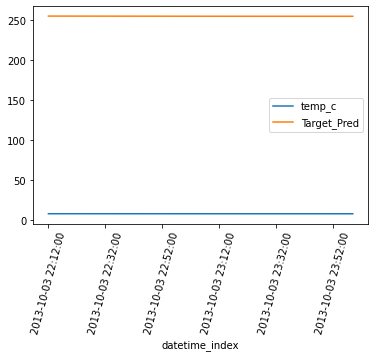

In [ ]:
# Visualize the NN Results
nn_results[['temp_c', 'Target_Pred']].plot()
plt.xticks(rotation = 75)



In [ ]:
nn_results['Target_Pred']

datetime_index
2013-10-03 22:12:00    8.074000
2013-10-03 22:13:00    8.073500
2013-10-03 22:14:00    8.073000
2013-10-03 22:15:00    8.072500
2013-10-03 22:16:00    8.072000
                         ...   
2013-10-03 23:55:00    8.031667
2013-10-03 23:56:00    8.031333
2013-10-03 23:57:00    8.031000
2013-10-03 23:58:00    8.030667
2013-10-03 23:59:00    8.030333
Name: Target_Pred, Length: 108, dtype: float64

,depth_m,temp_c_at_depth,chlorophyll_ugl,conductivity_mscm,temp_c,turbidity_ftu,salinity_psu
datetime_index,,,,,,,
2013-10-03 00:00:00,255.820000,8.020000,0.0,36.100000,8.170000,0,34.5800
2013-10-03 00:01:00,255.814500,8.019667,0.0,36.105000,8.169833,0,34.5855
2013-10-03 00:02:00,255.809000,8.019333,0.0,36.110000,8.169667,0,34.5910
2013-10-03 00:03:00,255.803500,8.019000,0.0,36.115000,8.169500,0,34.5965
2013-10-03 00:04:00,255.798000,8.018667,0.0,36.120000,8.169333,0,34.6020
...,...,...,...,...,...,...,...
2013-10-03 23:55:00,255.961667,7.909167,0.0,36.239167,8.031667,0,34.8675
2013-10-03 23:56:00,255.959333,7.909333,0.0,36.239333,8.031333,0,34.8680
2013-10-03 23:57:00,255.957000,7.909500,0.0,36.239500,8.031000,0,34.8685


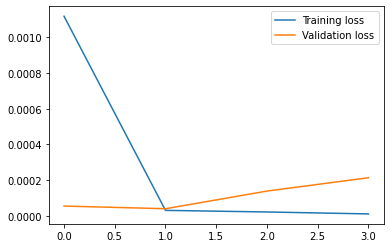

In [ ]:
# Evaluating Training
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

Anomaly Detection

The tutorial doesn't go that far to anomaly detection but forecast values instead.

In [ ]:
# Anomaly Detection

X_pred = nn_model.predict(test_generator)
X_pred[:5]

array([[0.01586161],
       [0.01588055],
       [0.01589618],
       [0.01590888],
       [0.01591899]], dtype=float32)